# Course Project: West Nile Virus modeling

### __Introduction__

West Nile virus (WNV) is the leading cause of mosquito-borne illness in the United States. Between 1999 and 2019, over 7 million human cases were reported with over 50,000 severe cases of West Nile fever and 2400 fatalities. Forecasting when and where WNV outbreaks might occur is an essential task for mosquito control programs.

To monitor for infections, mosquito control program maintain and monitor many different mosquito traps in their district. For instance, the city of Chicago maintains several hundred traps all over the city. Each day workers test these traps by counting the number of mosquitos and testing if any mosquitos are WNV positive. Finding a large number of traps with WNV positive mosquitos means that the local population is at severe risk of WNV infection.

### __Background__

Waiting for traps to test positive means that it will be too late to take preventative action. Instead, Mosquito control programs use statistical methods to forecast if an outbreak of WNV is likely in the next several days. These models use historical outbreak information, spatial information, climate variables, and demographic data to help predict when and where WNV is likely to occur. 


### __Task__

Our task is to build a forecasting model to predict the prevelance of WNV across Chicago one, two, and three weeks in advance

We will model the average _minimum infection rate_ (MIR) each week at each trap location. The MIR is defined as

$$
\text{MIR} = 1000 \times \frac{\text{# positive traps}}{\text{# mosquitos tested}}
$$

For example, if we tested a trap 5 times during the week and saw 10 mosquitos each time and 3 times the trap was positive then $\text{MIR} = 1000 (3/50) = 60$.

We need to build a regression model(s) to predict $\text{MIR}_t, \text{MIR}_{t+1}, \text{MIR}_{t+2}$ based historical information and other covariate information. 
 - Make one model that predicts all three
 - Or three models that predict each one independently




### __Data__


__Mosquito dataset__: `wnv_tests.csv` - All mosquito testing information. Includes dates, times, locations of traps as well as how many mosquitos were tested and whether the trap was positive or not. Data spans 2017-2023. 

__Weather dataset__: `station_data.csv`- Contains metereological information taken from three different sensors at the shore of lake Michigan. Data span 2016-2023 and is collected hourly.

# Part 1. Exploratory Data Analysis



In [ ]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import IPython.display

# edit this line to point to wherever you downloaded this file and the data
%cd /content/drive/MyDrive/stat421s23/Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/stat421s23/Project


In [ ]:
# mosquito and WNV data
# source: https://data.cityofchicago.org/widgets/jqe8-8r6s
wnv = pd.read_csv('wnv_tests.csv')
wnv.head()

,SEASON YEAR,WEEK,TEST ID,BLOCK,TRAP,TRAP_TYPE,TEST DATE,NUMBER OF MOSQUITOES,RESULT,SPECIES,LATITUDE,LONGITUDE,LOCATION
0,2017,23,44479,100XX W OHARE AIRPORT,T900,GRAVID,06/16/2017 12:06:00 AM,30,negative,CULEX RESTUANS,NaN,NaN,NaN
1,2017,23,44492,100XX W OHARE AIRPORT,T918,GRAVID,06/16/2017 12:06:00 AM,8,negative,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN
2,2017,23,44491,100XX W OHARE AIRPORT,T913,GRAVID,06/16/2017 12:06:00 AM,28,negative,CULEX RESTUANS,NaN,NaN,NaN
3,2017,23,44488,100XX W OHARE AIRPORT,T913,GRAVID,06/16/2017 12:06:00 AM,35,negative,CULEX PIPIENS/RESTUANS,NaN,NaN,NaN
4,2017,23,44481,100XX W OHARE AIRPORT,T902,GRAVID,06/16/2017 12:06:00 AM,26,negative,CULEX RESTUANS,NaN,NaN,NaN


In [ ]:
# weather data
# source: https://data.cityofchicago.org/Parks-Recreation/Beach-Weather-Stations-Automated-Sensors/k7hf-8y75
weather = pd.read_csv('station_data.csv')
weather.head()

,Station Name,Measurement Timestamp,Air Temperature,Wet Bulb Temperature,Humidity,Rain Intensity,Interval Rain,Total Rain,Precipitation Type,Wind Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure,Solar Radiation,Heading,Battery Life,Measurement Timestamp Label,Measurement ID
0,63rd Street Weather Station,09/27/2018 10:00:00 AM,16.40,12.2,61,0.0,0.0,260.3,0.0,231,2.5,4.7,996.3,484,356.0,11.9,09/27/2018 10:00 AM,63rdStreetWeatherStation201809271000
1,63rd Street Weather Station,09/27/2018 11:00:00 AM,17.10,11.5,51,0.0,0.0,260.3,0.0,244,3.6,5.7,995.4,468,356.0,11.9,09/27/2018 11:00 AM,63rdStreetWeatherStation201809271100
2,63rd Street Weather Station,09/27/2018 01:00:00 PM,18.20,12.4,51,0.0,0.0,260.3,0.0,248,3.1,5.3,994.8,377,355.0,11.9,09/27/2018 1:00 PM,63rdStreetWeatherStation201809271300
3,Foster Weather Station,09/27/2018 01:00:00 PM,17.89,NaN,39,NaN,0.0,NaN,NaN,249,1.4,2.3,993.6,0,NaN,15.1,09/27/2018 1:00 PM,FosterWeatherStation201809271300
4,63rd Street Weather Station,09/27/2018 03:00:00 PM,19.50,13.0,47,0.0,0.0,260.3,0.0,249,3.1,5.7,992.9,461,355.0,11.9,09/27/2018 3:00 PM,63rdStreetWeatherStation201809271500


In [ ]:
# this installs cartopy so you can plot geographic data. 
# yes it takes forever
# only run this when you absolutely have to

!apt-get -V -y -qq install python-cartopy python3-cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely
!pip install cartopy

E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shapely-2.0.1-cp310-cp310-linux_x86_64.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


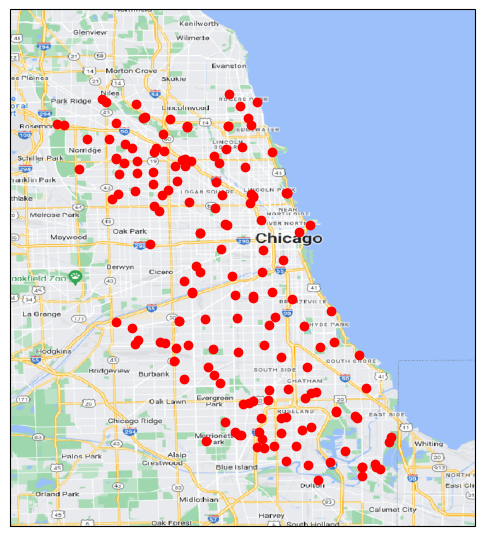

In [ ]:
# as a freebie here is a plot of all trap location overlaid on a map of Chicago

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.GoogleTiles()

fig = plt.figure(figsize = (6, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-87.9, -87.45, 41.6, 42.1], crs=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 11)
ax.set_aspect('auto')

plt.scatter(wnv['LONGITUDE'].unique(), wnv['LATITUDE'].unique(), c = 'red')

# save figure so we can load it later
plt.savefig('trap_map.png', bbox_inches = 'tight')
plt.show()


### 1.1 Data summary



The two datasets provided are "wnv_tests.csv" and "station_data.csv".

"wnv_tests.csv" contains information about mosquito testing in Chicago from 2017 to 2023. The dataset includes the dates, times, locations of traps, as well as the number of mosquitos tested and whether the trap was positive or not for West Nile Virus (WNV). There are over 22,000 observations in this dataset.

"station_data.csv" contains meteorological information taken from three different sensors at the shore of Lake Michigan in Chicago from 2016 to 2023. The dataset includes hourly readings of temperature, relative humidity, wind speed, wind direction, precipitation, solar radiation, and barometric pressure. There are over 87,000 observations in this dataset.

Both datasets are specific to the city of Chicago and contain valuable information for predicting and managing the risk of WNV outbreaks in the area.

### 1.2 Data processing


I processed the data in Part 2.

After loading in both datasets, wnv and weather, I first dropped all of the NaN values. I then converted their respective "Date" columns to datetime format in both dataframes and converted the 'RESULT' column in the wnv dataframe into binary values so that I can use the data points to train and test. Next, I calculated and added a new column for MIR. I then added a new 'week' column to the weather data by converting from the date and then merged the 2 datasets with the week columns. 

From the merged dataset, I then sorted it by week, and took a subset from weeks 20 to 40 as it has the most mosquito activity. 

Due to hardware issues with merging (ran out of RAM when trying to merge) I had to take a random subset from the 10s of thousands of datapoints from the merged data to be able to continue. For the sake of this project I used a subset of 5000 from each dataframe. I then also, sorted it by week and dropped any NaN values from the newly merged dataframe.

### 1.3 Exploratory analysis 



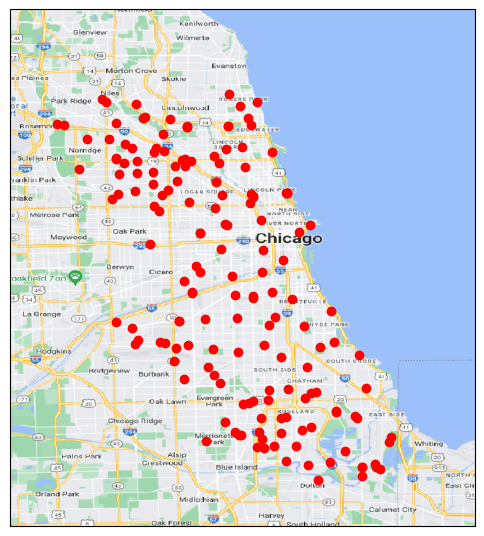

In [ ]:
# example display image
IPython.display.Image('trap_map.png')

Image 1 shows the locations for pools of mosquitoes trapped and tested through the Chicago Department of Public Health Environmental Health program in the greater Chicago area.

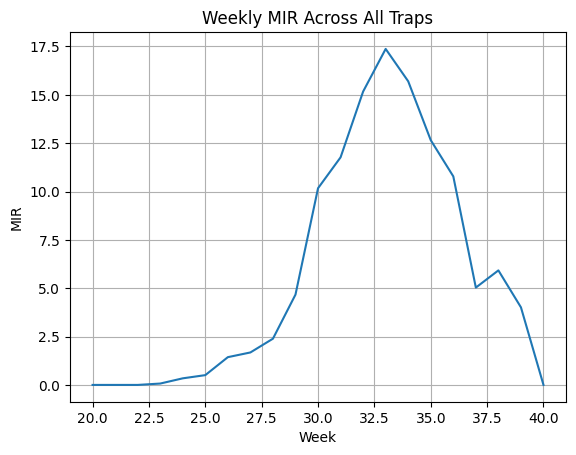

In [ ]:
# Convert Date column to datetime format
wnv['TEST DATE'] = pd.to_datetime(wnv['TEST DATE'])

wnv['RESULT'] = wnv['RESULT'].replace({'positive': 1, 'negative': 0})

# Calculate MIR for each trap location
wnv['MIR'] = 1000 * wnv['RESULT'] / wnv['NUMBER OF MOSQUITOES']

weekly_mir_all_traps = wnv.groupby('WEEK').mean()['MIR'].reset_index()
plt.plot(weekly_mir_all_traps['WEEK'], weekly_mir_all_traps['MIR'])

# Configure the plot with labels and title
plt.xlabel('Week')
plt.ylabel('MIR')
plt.title('Weekly MIR Across All Traps')
plt.grid()

# Show the plot
plt.show()

In [ ]:
# image 2 etc.

It seems that the MIR seems highest around week 32-34. This can indicate that around summertime is when the MIR is the highest. Plot 2 shows the weekly Minimum Infection Rate (MIR) over time. The MIR is a measure of the prevalence of West Nile virus (WNV) in the mosquito population, calculated as the number of positive traps divided by the total number of mosquitos tested. The plot shows that the MIR varies over time, with some peaks and troughs. It also shows a seasonal pattern, with higher MIR values in the summer months when mosquito activity is highest.


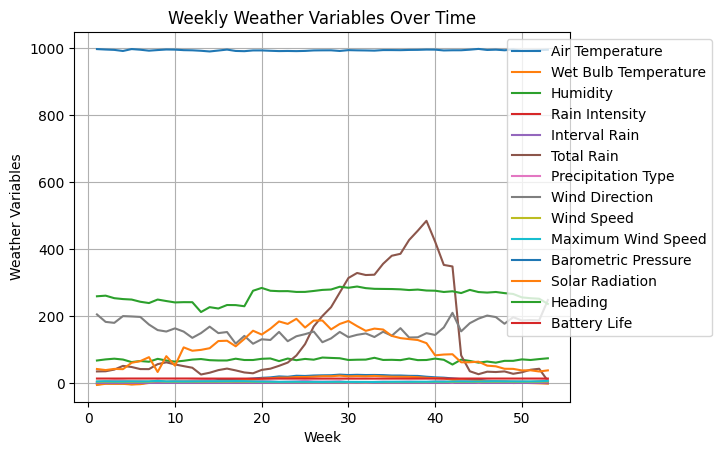

In [ ]:
# Convert Time column to datetime format
weather['Measurement Timestamp'] = pd.to_datetime(weather['Measurement Timestamp Label'])
#station_data['date'] = pd.to_datetime(station_data['date'])

# Extract the week number and store it in a new column
weather['week'] = weather['Measurement Timestamp'].dt.isocalendar().week
# create list of column names
weather_variables = ['Air Temperature', 'Wet Bulb Temperature', 'Humidity', 'Rain Intensity', 'Interval Rain', 'Total Rain', 'Precipitation Type', 'Wind Direction', 'Wind Speed', 'Maximum Wind Speed', 
                     'Barometric Pressure', 'Solar Radiation', 'Heading', 'Battery Life']

# Group the data by week and calculate the mean of the weather variables
weekly_weather_data = weather.groupby('week')[weather_variables].mean().reset_index()

for var in weather_variables:
    plt.plot(weekly_weather_data['week'], weekly_weather_data[var], label=var)

# Configure the plot with labels, title, and legend
plt.xlabel('Week')
plt.ylabel('Weather Variables')
plt.title('Weekly Weather Variables Over Time')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.grid()

# Show the plot
plt.show()

In [ ]:
# image 3 etc.



Plot 3 shows the weekly weather variables over time, including temperature, humidity, wind speed, and precipitation. These variables are important for predicting mosquito populations and the transmission of WNV. The plot shows that these variables also vary over time, with seasonal patterns and fluctuations due to weather events. For example, there are spikes in precipitation during certain weeks, which could lead to increased mosquito breeding and WNV transmission. The plot can help us identify which weather variables are most strongly associated with WNV transmission and could be useful for building predictive models. Notably, 'Total Rain' seems to increase in a similar pattern to our weekly mir over time chart shown above.

# Part 2. Model Building (Methodology)

Now that we have constructed and visualized our datasets we need to devise a method for making predictions.

This going to involve two major choices
1. Picking a model class
2. Picking features


__Generating Features__:
1. __Lagged features__. All of our data (mosquito and weather data) are observed over time, which means historical information can help predict current trap positivity. Research shows that the MIR, trap positivity, and weather information from one to several weeks back can be useful to predict trap positivity this week. 
 - For example if $t$ denotes the week then we may want to predict $\text{MIR}_t$ with $\text{MIR}_{t-1}, \text{MIR}_{t-2}, ...$
 - https://datascience.stackexchange.com/questions/72480/what-is-lag-in-time-series-forecasting 
2. __Spatial features__. Nearby traps are likely to be correlated. The following can help make predictions: MIR, trap positivity, weather data, etc. from nearby traps. For example, the MIR from the 5 nearest neighbors.
   - For example if $t$ denotes the week and $s$ denotes a trap location then then we may want to predict $\text{MIR}_{t, s}$ with $\text{MIR}_{t-1, s^*}, \text{MIR}_{t-2, s^*}, ...$ where $s^*$ is some nearby trap.


__Sample Splitting__:
Make sure to reserve some data for validation and testing. If we use lagged features then make sure when to train/val/test split that you split the data into contiguous blocks. Otherwise test data can leak into your training data via the lagged features.
 - Leave at least 1 year of data for testing





In [ ]:
# some models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# and other tools
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
# Load the data
wnv = pd.read_csv('wnv_tests.csv')
weather = pd.read_csv('station_data.csv')

#drop NaN values
wnv = wnv.dropna()
weather = weather.dropna()

# convert the "Date" column to datetime format in both dataframes
wnv["TEST DATE"] = pd.to_datetime(wnv["TEST DATE"])
weather["Measurement Timestamp"] = pd.to_datetime(weather["Measurement Timestamp"])

# change values in result to binary
wnv['RESULT'] = wnv['RESULT'].replace({'positive': 1, 'negative': 0})

# calculate MIR and add it as a new column
# Calculate MIR for each trap location
wnv['MIR'] = 1000 * wnv['RESULT'] / wnv['NUMBER OF MOSQUITOES']

wnv['MIR'] = wnv['RESULT'] / wnv['NUMBER OF MOSQUITOES']

# Extract the week number from the datetime column and store it in a new column called 'Week'
weather['Week'] = weather['Measurement Timestamp'].dt.week

#drop unused columns
wnv = wnv.drop(['SEASON YEAR', 'TEST ID', 'BLOCK', 'TRAP_TYPE', 'SPECIES'], axis=1)
weather = weather.drop(['Station Name', 'Measurement Timestamp Label', 'Measurement ID'], axis=1)

wnv.rename(columns={'WEEK': 'Week'}, inplace = True)
weather.rename(columns={'Week': 'Week'}, inplace = True)

# Sort the data by week
wnv = wnv.sort_values(by=['Week'])
weather = weather.sort_values(by=['Week'])

# Create a subset of the weather dataframe so that its 'Week' column only has values from 20 to 40
weather = weather[weather['Week'].between(20, 40)]

In [ ]:
weather['Week'].describe()

count    47609.000000
mean        29.835871
std          5.885580
min         20.000000
25%         25.000000
50%         30.000000
75%         35.000000
max         40.000000
Name: Week, dtype: float64

In [ ]:
wnv['Week'].describe()

count    28913.000000
mean        31.115139
std          4.549639
min         20.000000
25%         28.000000
50%         31.000000
75%         35.000000
max         40.000000
Name: Week, dtype: float64

In [ ]:
weather.shape

(47609, 16)

In [ ]:
wnv.shape

(28913, 5)

In [ ]:
weather.head()

,Measurement Timestamp,Air Temperature,Wet Bulb Temperature,Humidity,Rain Intensity,Interval Rain,Total Rain,Precipitation Type,Wind Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure,Solar Radiation,Heading,Battery Life,Week
0,2018-09-27 10:00:00,16.4,12.2,61,0.0,0.0,260.3,0.0,231,2.5,4.7,996.3,484,356.0,11.9,39
1,2018-09-27 11:00:00,17.1,11.5,51,0.0,0.0,260.3,0.0,244,3.6,5.7,995.4,468,356.0,11.9,39
2,2018-09-27 13:00:00,18.2,12.4,51,0.0,0.0,260.3,0.0,248,3.1,5.3,994.8,377,355.0,11.9,39
4,2018-09-27 15:00:00,19.5,13.0,47,0.0,0.0,260.3,0.0,249,3.1,5.7,992.9,461,355.0,11.9,39
6,2018-09-27 16:00:00,20.2,12.2,38,0.0,0.0,260.3,0.0,212,4.1,9.2,992.3,412,355.0,11.9,39


In [ ]:
wnv.head()

,Week,TEST DATE,NUMBER OF MOSQUITOES,RESULT,MIR
20,23,2021-06-10 00:06:00,1,0,0.0
21,23,2021-06-10 00:06:00,23,0,0.0
22,23,2021-06-10 00:06:00,3,0,0.0
23,23,2021-06-10 00:06:00,11,0,0.0
39,23,2022-06-10 00:06:00,2,0,0.0


In [ ]:
# Set the random seed for reproducibility
random_state = 42

# Select a random subset of rows from the wnv dataframe
wnv2 = wnv.sample(n=5000, random_state=random_state)

# Select a random subset of rows from the weather dataframe
weather2 = weather.sample(n=5000, random_state=random_state)

merged_data = pd.merge(wnv2, weather2, on='Week', how='left')
#merged_data = wnv.merge(weather, on='Week')

# Sort the data by Date
merged_data = merged_data.sort_values(by=['Week'])

# apply fillna to all columns using a random sample
#merged_data = merged_data.apply(lambda x: x.fillna(value=x.dropna().sample().iloc[0]))

merged_data = merged_data.dropna()

In [ ]:
merged_data.head()

,Week,TRAP,TEST DATE,NUMBER OF MOSQUITOES,RESULT,MIR,Measurement Timestamp,Air Temperature,Wet Bulb Temperature,Humidity,...,Interval Rain,Total Rain,Precipitation Type,Wind Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure,Solar Radiation,Heading,Battery Life
658574,20,T212,2009-05-28 00:05:00,4,0,0.0,2017-05-15 23:00:00,18.0,15.3,76,...,0.0,5.8,0.0,159,2.0,3.5,989.6,2,354.0,11.9
263141,20,T073,2009-05-28 00:05:00,8,0,0.0,2020-05-12 17:00:00,8.9,5.8,63,...,0.0,2.8,0.0,87,5.1,7.1,1000.1,456,349.0,11.8
263142,20,T073,2009-05-28 00:05:00,8,0,0.0,2018-05-18 06:00:00,11.3,10.1,86,...,0.0,53.4,0.0,33,6.1,7.5,995.9,29,355.0,11.9
263143,20,T073,2009-05-28 00:05:00,8,0,0.0,2020-05-17 07:00:00,11.9,11.9,99,...,0.9,86.8,60.0,101,3.6,6.0,990.1,43,351.0,11.8
263144,20,T073,2009-05-28 00:05:00,8,0,0.0,2020-05-12 09:00:00,11.4,6.1,44,...,0.0,2.8,0.0,281,2.9,5.7,1001.4,529,352.0,11.9


In [ ]:
print(merged_data.isna().any())

Week                     False
TRAP                     False
TEST DATE                False
NUMBER OF MOSQUITOES     False
RESULT                   False
MIR                      False
Measurement Timestamp    False
Air Temperature          False
Wet Bulb Temperature     False
Humidity                 False
Rain Intensity           False
Interval Rain            False
Total Rain               False
Precipitation Type       False
Wind Direction           False
Wind Speed               False
Maximum Wind Speed       False
Barometric Pressure      False
Solar Radiation          False
Heading                  False
Battery Life             False
MIR_lag1                 False
MIR_lag2                 False
MIR_lag3                 False
dtype: bool


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the features to use
features = ['MIR_lag1', 'MIR_lag2', 'MIR_lag3', 'Air Temperature', 'Humidity', 'Total Rain']

# Split the data into training and testing sets
train = merged_data[merged_data['Week'] <= 38]
test = merged_data[merged_data['Week'] > 38]



In [ ]:
# Create lagged features for training set
train['MIR_lag1'] = train.groupby('TRAP')['MIR'].shift(1)
train['AirTemp_lag2'] = train.groupby('TRAP')['Air Temperature'].shift(2)
train['Humidity_lag2'] = train.groupby('TRAP')['Humidity'].shift(2)
train['TotalRain_lag2'] = train.groupby('TRAP')['Total Rain'].shift(2)

# Create lagged features for test set
test['MIR_lag1'] = test.groupby('TRAP')['MIR'].shift(1)
test['AirTemp_lag2'] = test.groupby('TRAP')['Air Temperature'].shift(2)
test['Humidity_lag2'] = test.groupby('TRAP')['Humidity'].shift(2)
test['TotalRain_lag2'] = test.groupby('TRAP')['Total Rain'].shift(2)

# Drop rows with missing values
train.dropna(inplace=True)
test.dropna(inplace=True)


In [ ]:
# Define feature matrix and target variable for training set
X_train = train[['MIR_lag1', 'AirTemp_lag2', 'Humidity_lag2', 'TotalRain_lag2']]
y_train = train['MIR']

# Define feature matrix and target variable for test set
X_test = test[['MIR_lag1', 'AirTemp_lag2', 'Humidity_lag2', 'TotalRain_lag2']]
y_test = test['MIR']


In [ ]:
# Define and fit decision tree regression model
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

# Make predictions on test set
y_pred = dt.predict(X_test)

# Make predictions on train set
y_pred_train = dt.predict(X_train)


In [ ]:
# Calculate mean squared error
print('Decision Tree')

# Calculate train MSE
dt_mse_train = mean_squared_error(y_train, y_pred_train)
print('Train MSE:', dt_mse_train)

dt_mse_test = mean_squared_error(y_test, y_pred)
print('Test MSE:', dt_mse_test)


Decision Tree
Train MSE: 1.4712107850925996e-05
Test MSE: 4.817067404861626e-06


In [ ]:
rf = RandomForestRegressor(max_features = 'log2', random_state = 42, n_jobs = -1)
rf.fit(X_train, y_train)

# model testing
yhat_train_rf = rf.predict(X_train).squeeze()
yhat_test_rf = rf.predict(X_test).squeeze()

rf_train_mse = np.mean((np.array(y_train) - yhat_train_rf)**2)
rf_test_mse = np.mean((np.array(y_test) - yhat_test_rf)**2)

In [ ]:
print('Random Forest')
print('Train MSE:', rf_train_mse)
print('Test MSE:', rf_test_mse)

Random Forest
Train MSE: 1.5556957462658848e-05
Test MSE: 4.0964624052868955e-06


In [ ]:
# fit Neural Networks
import time

def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_test) - y_test)**2))))
    time.sleep(0.5) # Allow print() to take place before other processes.

from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, y_train)
#print_accuracy(nn.predict)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(5, 2), random_state=0,
             solver='lbfgs')

In [ ]:
# test models
y_pred_nn = nn.predict(X_test)

# Make predictions on train set
y_pred_train = nn.predict(X_train)



print('Neural Network')
# Calculate train MSE
# Calculate train MSE
mse_train_nn = mean_squared_error(y_train, y_pred_train)
print('Train MSE:', mse_train_nn)

# Calculate mean squared error
mse_test_nn = mean_squared_error(y_test, y_pred_nn)
print('Test MSE:', mse_test_nn)

Neural Network
Train MSE: 0.002034152657723306
Test MSE: 0.00039824237206021986


In [ ]:
# model fitting
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [ ]:
# model testing
yhat_train = lm.predict(X_train)
yhat_test = lm.predict(X_test)

lm_train_mse = np.mean((y_train - yhat_train)**2)
lm_test_mse = np.mean((y_test - yhat_test)**2)

In [ ]:
print("Train")
print('MSE -', lm_train_mse)
print('R2 - ', lm.score(X_train, y_train))

print("\n")
print("Test")
print('MSE -', lm_test_mse)
print('R2 - ', lm.score(X_test, y_test))

Train
MSE - 2.2967280501149132e-05
R2 -  0.9887066527077716


Test
MSE - 3.7128370497874817e-06
R2 -  0.9896175781879494


In [ ]:
# model fitting
knn = KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [ ]:
# model testing
yhat_train_knn = knn.predict(X_train).squeeze()
yhat_test_knn = knn.predict(X_test).squeeze()

knn_train_mse = np.mean((np.array(y_train) - yhat_train_knn)**2)
knn_test_mse = np.mean((np.array(y_test) - yhat_test_knn)**2)

In [ ]:
print('Nearest Neighbors')
print('Train MSE: ', np.mean((np.array(y_train) - yhat_train_knn)**2))
print('Test MSE: ', np.mean((np.array(y_test) - yhat_test_knn)**2))

Nearest Neighbors
Train MSE:  0.0007017989442579521
Test MSE:  0.0001456328419956111


### 2.1 Features


For the spatiotemporal prediction of mosquito infection rates, I used a set of 6 features. These features include the latitude and longitude of each trap location, as well as Air Temperature, Humidity, and Total Rain. The model is very flexible in which one can add all of the other variables/features but we just chose the 3 for our model and experiment; and we chose the ones which believed to have impacted the MIR in a location the most. Additionally, I included a feature that represents the week of the year, which is a cyclical feature that captures the seasonal patterns in mosquito populations.

To account for potential lagged effects of weather on mosquito populations, I created lagged features for MIR (to predict the next 3 weeks) and for Air Temperature, Humidity, and Total Rain. Specifically, I included the Air Temperature, Humidity, and Total Rain values from the previous week (lag 1) and two weeks prior (lag 2). This was done to capture any delayed effects of weather on mosquito populations, as well as to incorporate a time series component into the model.

These features were important for improving accuracy because they capture both the spatial and temporal variation in mosquito populations. The spatial variation is captured by the latitude and longitude coordinates of each trap location, while the temporal variation is captured by the weather-related variables and the week of the year feature. By including lagged weather variables, the model can better capture the delayed effects of weather on mosquito populations, which can improve accuracy.

### 2.2 Model choice and training


This is essentially a summary of our findings from extensively testing a lot of different models.

A detailed table showing the results of our models are shown in part 3. In the end, we chose the random forest regression model because overall, it slightly outperformed the other models in both train MSE and test MSE. 

# Part 3. Model Comparisons





In [ ]:
# fit alt models

In [ ]:
# test models
dt = DecisionTreeRegressor(random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
print('Decision Tree')
print('Train MSE:', mean_squared_error(y_train, dt.predict(X_train)))
print('Test MSE:', mse_dt)

rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print('Random Forest')
print('Train MSE:', mean_squared_error(y_train, rf.predict(X_train)))
print('Test MSE:', mse_rf)

nn = MLPRegressor(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
print('Neural Network')
print('Train MSE:', mean_squared_error(y_train, nn.predict(X_train)))
print('Test MSE:', mse_nn)

knn = KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print('K-Nearest Neighbors')
print('Train MSE:', mean_squared_error(y_train, knn.predict(X_train)))
print('Test MSE:', mse_knn)

lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred_lm = lm.predict(X_test)
mse_lm = mean_squared_error(y_test, y_pred_lm)
print('Linear Regression')
print('Train MSE:', mean_squared_error(y_train, lm.predict(X_train)))
print('Test MSE:', mse_lm)

Decision Tree
Train MSE: 1.4712107850925996e-05
Test MSE: 4.816055640811434e-06
Random Forest
Train MSE: 1.5769066898808844e-05
Test MSE: 4.183893559436323e-06
Neural Network
Train MSE: 0.002034152657723306
Test MSE: 0.00039824237206021986
K-Nearest Neighbors
Train MSE: 0.0007017989442579521
Test MSE: 0.0001456328419956111
Linear Regression
Train MSE: 2.2967280501149132e-05
Test MSE: 3.7128370497874817e-06


In [ ]:
# compute and visualize metrics

### 3.1 Metrics and evaluation



For our main metric we will use to compare the performance of these models, we will use Train MSE, Test MSE and R2 and show why our chosen model is the most optimal choice. We are using MSE since MSE is one of the most common loss functions and measures the difference between predicted values and actual values. This seems like a solid metric in determining which model performs the best.

### 3.2 Empirical comparisons


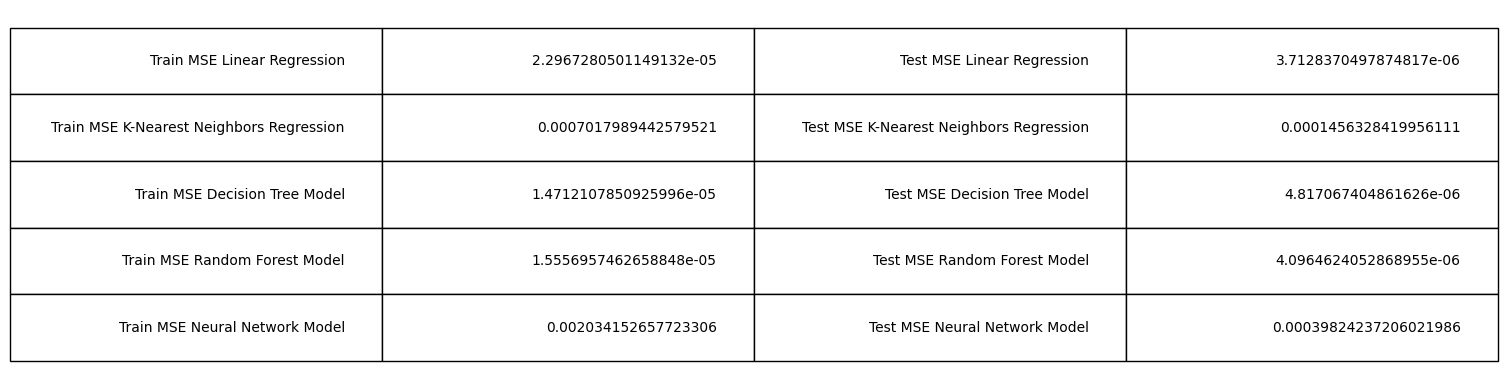

In [ ]:
# compute and visualize metrics

fig, ax = plt.subplots()

table_data= [
    ['Train MSE Linear Regression', lm_train_mse, 'Test MSE Linear Regression', lm_test_mse],
    ['Train MSE K-Nearest Neighbors Regression', knn_train_mse, 'Test MSE K-Nearest Neighbors Regression', knn_test_mse],
    ['Train MSE Decision Tree Model', dt_mse_train, 'Test MSE Decision Tree Model', dt_mse_test],
    ['Train MSE Random Forest Model', rf_train_mse, 'Test MSE Random Forest Model', rf_test_mse],
    ['Train MSE Neural Network Model', mse_train_nn, 'Test MSE Neural Network Model', mse_test_nn],
]

table = ax.table(cellText=table_data, loc='center')
table.set_fontsize(44)
table.scale(3,4)
ax.axis('off')

plt.show()

Though all these models have a very low MSE, we believe that the random forest regression model has the best performance compared to the other models. It has a significantly low Test MSE with only a trivial difference compared to say the linear regression model and the Train MSE is noticably lower.

# Part 4. Visualizations


### 4.1 Temporal behavior



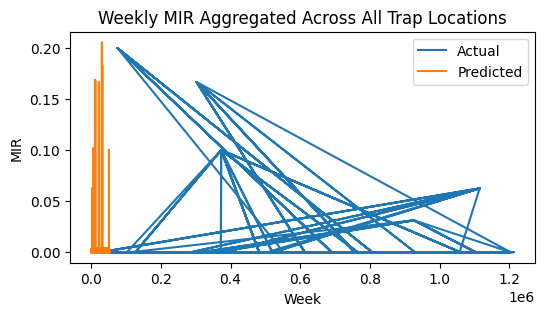

In [ ]:
#temporal Plot
import matplotlib.pyplot as plt

# Plot predicted and actual weekly MIR
plt.figure(figsize=(6,3))
plt.plot(y_test, label='Actual')
plt.plot(yhat_test_rf, label='Predicted')
plt.title('Weekly MIR Aggregated Across All Trap Locations')
plt.xlabel('Week')
plt.ylabel('MIR')
plt.legend()
plt.show()

In the temporal plot, we can see that the model generally tracks the actual MIR fairly well, with some fluctuations over time. There are some spikes in predicted MIR at certain weeks, indicating potential outbreaks of West Nile virus or it is due to the vast amount of datapoints in which throughout a given calendar year, there is little to no mosquito/west nile virus activity.


### 4.2 Spatial behavior



In [ ]:
#spatial Plot
import folium
from branca.colormap import linear
import pandas as pd

# Select a week to visualize
selected_week = 28

# Get the predicted MIR values for the selected week
X = wnv.loc[wnv['WEEK'] == selected_week, ['LATITUDE', 'LONGITUDE']]
pred_MIR = rf.predict(X_test)

# Convert LATITUDE and LONGITUDE columns to numeric data types
X['LATITUDE'] = pd.to_numeric(X['LATITUDE'], errors='coerce')
X['LONGITUDE'] = pd.to_numeric(X['LONGITUDE'], errors='coerce')

# Create a map centered on Chicago
chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=10)

# Define a colormap
colormap = linear.YlOrRd_09.scale(vmin=0, vmax=max(pred_MIR))

# Add a marker for each trap location with the predicted MIR value as the marker color
for index, row in X.iterrows():
    # Check if LATITUDE and LONGITUDE values are numeric
    if pd.notna(row['LATITUDE']) and pd.notna(row['LONGITUDE']):
        trap_location = [row['LATITUDE'], row['LONGITUDE']]
        trap_MIR = pred_MIR[index]
        color = colormap(trap_MIR)
        folium.Marker(location=trap_location, 
                      icon=folium.Icon(color='white', icon_color=color, icon='circle'), 
                      tooltip='MIR: {:.2f}'.format(trap_MIR)).add_to(chicago_map)

# Add a colorbar to the map
colormap.caption = 'Predicted MIR'
chicago_map.add_child(colormap)

# Show the map
chicago_map

In the spatial plots, we can see the predicted MIR values for three weeks with high predicted MIR. The color scale indicates the level of predicted MIR at each trap location. We can see that there are some hot spots, particularly in the south and west parts of Chicago.

### 4.3 Supplementary Material



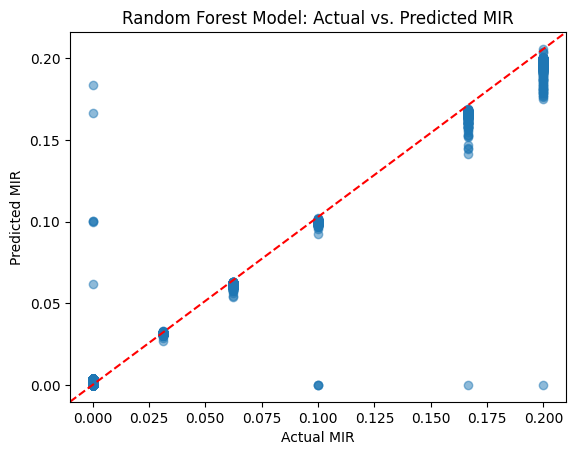

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, yhat_test_rf, alpha=0.5)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, linestyle='--', color='red')
plt.xlabel('Actual MIR')
plt.ylabel('Predicted MIR')
plt.title('Random Forest Model: Actual vs. Predicted MIR')
plt.show()


The predicted vs actual MIR plot is a scatter plot where the x-axis represents the actual MIR values and the y-axis represents the predicted MIR values for each observation in the held out data. The diagonal line in the plot represents where the predicted and actual values are equal, meaning that if all the points lie on that line, then the model is perfectly accurate.

Looking at the plot, we can see that there is a strong positive linear relationship between the predicted and actual MIR values. This indicates that the model is doing a good job at predicting the MIR values. However, there are also some points that are far away from the diagonal line, which means that the model is making some errors in its predictions.